#### Importing the libraries 

In [1]:
import segyio ## library for reading and manipulating segy files 
import matplotlib.pyplot as plt ## library for plotting
import numpy as np ## library for arrays
from scipy import ndimage as ndi ## library for scientific calc and image processing
from shutil import copyfile  ## for files management
from skimage import exposure ## image processing
import pandas as pd ## arrays, data handling
import openpyxl ## excel file rader/write

#### Importing the segy file and converting it into DataFrame (Pandas)

In [2]:
filename='C:/Users/abdul/Downloads/seismic.segy'  # write path where seismic.segy file is downloaded
f=segyio.open(filename, 'r+', strict=False, ignore_geometry=True) ## opening segy file for reading

In [3]:
print(type(filename))
print(type(f))

<class 'str'>
<class 'segyio.segy.SegyFile'>


In [4]:
frames = [pd.DataFrame(f.trace[i] for i in range(0,120120,1))] ## getting all 1001 shots data, 1001*120 =120120 traces
print(type(frames))
result = pd.concat(frames)
print(type(result))
# result.to_excel('C:/Users/abdul/Downloads/ejaz1.xlsx', index=False)

<class 'list'>
<class 'pandas.core.frame.DataFrame'>


In [5]:
sg2=result.T ## transpose of data (1500 rows by 120120 columns (traces))

In [6]:
sg2 = pd.DataFrame(sg2.astype('float64')) # converting data to float64 type

In [7]:
print((sg2.shape))

(1500, 120120)


#### handling missing shots

In [8]:
mis = [80,81,88,89,90,449,450,451,759,760,761] ## 1012 shots were recorded, of which 11 got missed
slistc =list(range(1,1013)) 
slist=[0]*len(slistc)
z=1
for i in slistc:
    if i not in mis:
        slist[i-1]=z ## list containing the position of missed shots
        z+=1

#### basic geometry and parameters

In [9]:
so, dx, nt, fold = 262, 25, 120, 60 ## source offset to first trace, trace interval, no. of trace per shot, trace per CMP gather
fs = 250  # sampling frequency
dt = 1 / fs  # sampling interval
td = 1500 * dt # total duration
df = 1 / td ## frequency interval
dw = 2 * np.pi * df ## frequency interval in rad/s
t = np.arange(0, td, dt) ## time vector

#### Function for extracting the 60 fold CMP gather from the 60 shot data 

In [10]:
def extsg(sg2, k): ## sg2 is whole data set. k = shot number from 1001 shots 
    
    idx = slist.index(k)
    offsets = np.array([])
    i=0
    j=np.array([])
    while i < fold:
        if slist[i+idx]==0: ## if shot is missed then ignore it and continue checking for correct data 
            i+=1
            # print('mis')
            continue
        offsets=np.append(offsets,np.array([so + 2*i*dx]))  ## offsets to each receiver considering missed shots
        j = np.append(j, np.array([k*nt-1 + i*118])) ## index for picked trace from sg2 to form a cmp gather
        i += 1
        
    sg = pd.DataFrame(0.0, index=range(1500), columns=range(len(j))) 
    sg.iloc[:,0:len(j)] = sg2.iloc[:,j] ## extracted cmp gather from whole data 
    return sg, offsets
    

#### Functions for NMO correction

In [11]:
def nmo_correction(sgn, dt, offsets, vnmo): ## here velocities is single value for doing semblance analysis.
    nmo = np.zeros_like(sgn)
    nsamples = 1500 
    times = np.arange(0, nsamples*dt, dt)
    for i, t0 in enumerate(times):
        for j, s0 in enumerate(offsets):
            if t0*vnmo<=8:
                break
            tt = reflection_time(t0, s0, vnmo) ## reflection time calculated using t0, s0, and nmo velocity
            amplitude = sample_trace(sgn[:, j], tt, dt) 
            if amplitude is not None: 
                nmo[i, j] = amplitude 
    return nmo

In [247]:
# def reflection_time(t0, x, vnmo): 
#     t = np.sqrt(t0**2 + x**2/vnmo**2) 
#     return t

#### Modified reflection time to counter differential elevation in source and receivers

In [12]:
def reflection_time(t0,s0,vnmo):
    xd = 4*s0/(vnmo*t0-4)
    s1= np.sqrt((vnmo*t0/2)**2+((s0+xd)/2)**2)
    s2= np.sqrt((vnmo*t0/2-4)**2 + ((s0-xd)/2)**2)
    t= (s1+s2)/vnmo
    return t

In [13]:
from scipy.interpolate import CubicSpline 

def sample_trace(trace, time, dt): 
    before = int(np.floor(time/dt)) 
    N = trace.size 
    samples = np.arange(before-1, before + 3) 
    if any(samples < 0) or any(samples >= N): 
        amplitude = None 
    else: 
        times = dt*samples 
        amps = trace[samples] 
        interpolator = CubicSpline(times, amps) 
        amplitude = interpolator(time) # amplitude is ndarray of size 1 and shape == (). it is a scalar. cubicpline is used to interpolate value
        ## of trace amplitude corresponding to reflection time.
        amplitude = amplitude[()] # converting ndarray to numpy.float64
    return amplitude

#### Balancing the traces to rms level

In [14]:
def balance_trace(trace):
    """
    Balance a single seismic trace to a common rms level.
    """
    # Calculate the rms value of the trace
    rms_value = np.sqrt(np.mean(trace ** 2))

    # Scale the trace to the common rms level (e.g., 1.0)
    balanced_trace = trace / rms_value

    return balanced_trace

def balance_seismic_data(seismic_data):
    """
    Balance all traces in a seismic data set to a common rms level.
    """
    balanced_seismic_data = np.zeros_like(seismic_data)

    # Balance each trace individually
    for i in range(seismic_data.shape[1]):
        balanced_seismic_data[:, i] = balance_trace(seismic_data[:, i])

    return balanced_seismic_data

#### Function for semblance coefficient

In [15]:
def sem(nmc):
    # k = 5
    seb = np.zeros((1500))
    for k in range(5,1495,1):
        sumnum=0
        sumden=0
        for j in range(k-5,k+6,1):
            sumnum += (np.sum(nmc[j,:]))**2
            sumden += np.sum(nmc[j,:]**2)
        if sumden != 0:
            seb[k] = sumnum/sumden/nmc.shape[1]
    return seb

In [16]:
def f_nmo_correction(sgn, dt, offsets, velocities):  ## here velocities is a vector containing velocity function with time.
    # nmo = pd.DataFrame(0, index=range(sz[0]), columns=range(sz[1]))
    nmo = np.zeros_like(sgn)
    # print(nmo.iloc[1499,59])
    nsamples = 1500 #cmp.shape[0] 
    times = np.arange(0, nsamples*dt, dt)
    for i, t0 in enumerate(times):
        for j, s0 in enumerate(offsets):
            if t0*velocities[i]<=8:
                # print('t0 = ', t0, ',vnmo= ', velocities, ',offset= ', x)
                break
            tt = reflection_time(t0, s0, velocities[i])
            # print('t0 = ', t0, ',vnmo= ', velocities, ',offset= ', x, ', ref time = ', tt, ',xd = ', xd)
            amplitude = sample_trace(sgn[:, j], tt, dt) 
            if amplitude is not None: 
                nmo[i, j] = amplitude 
    return nmo

#### CMP stack analysis (20 CMPs)

1


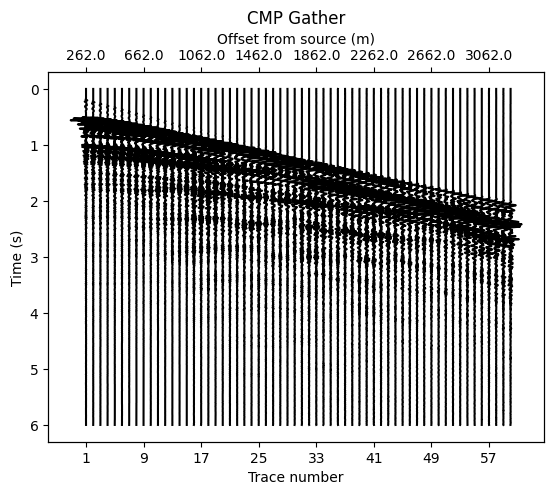

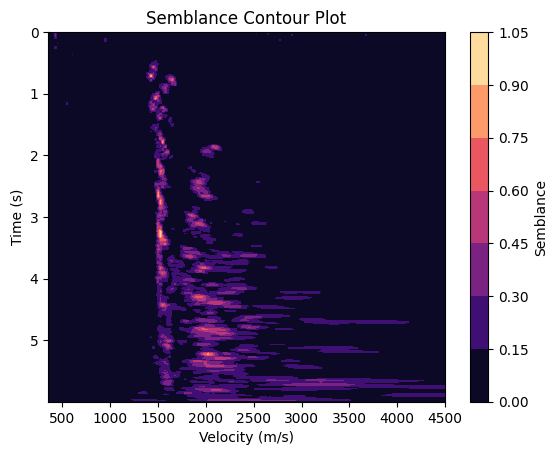

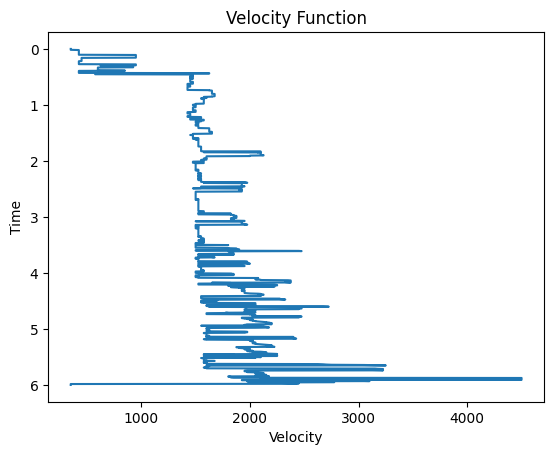

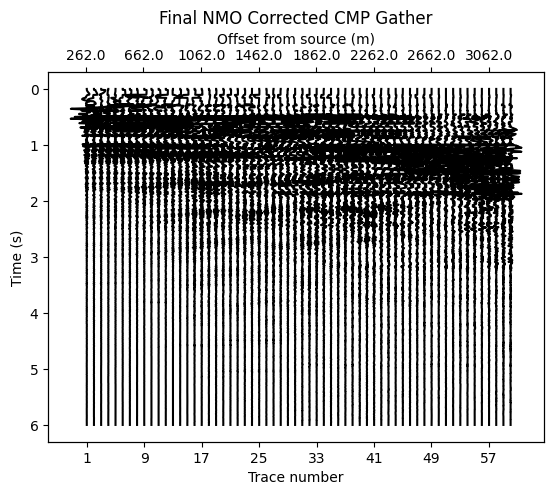

50


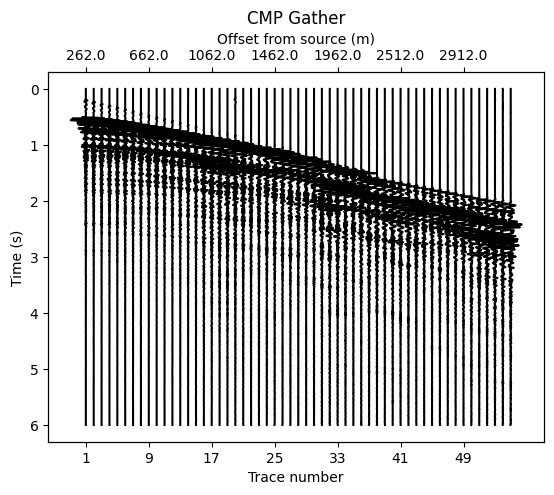

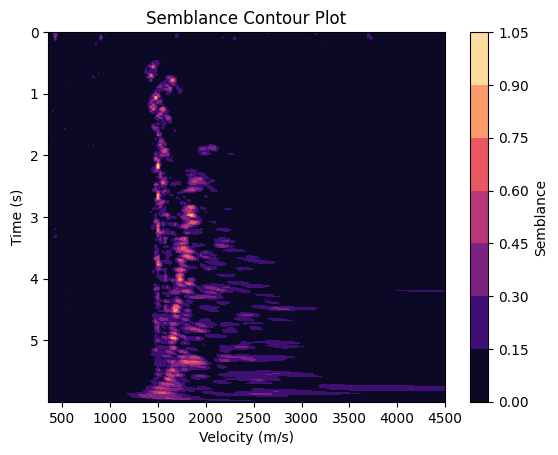

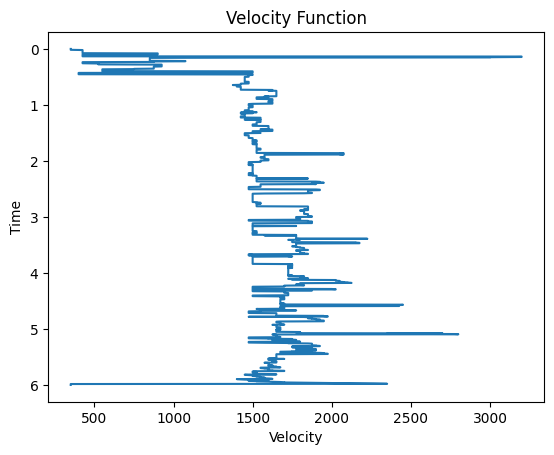

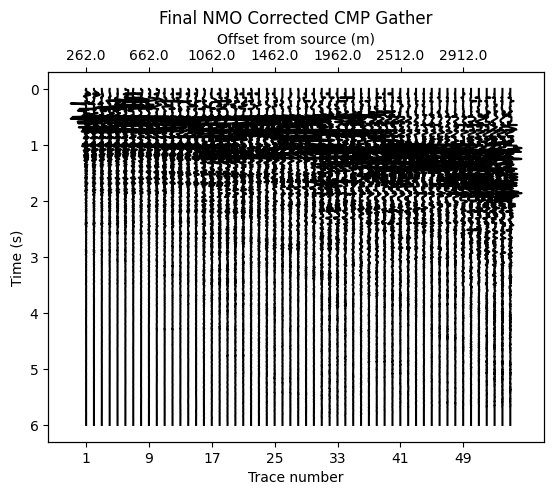

99


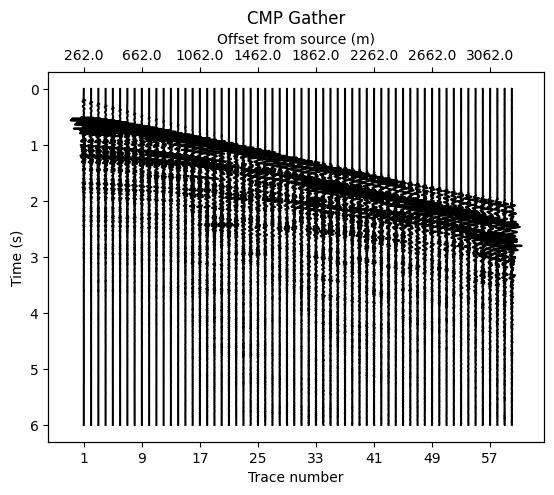

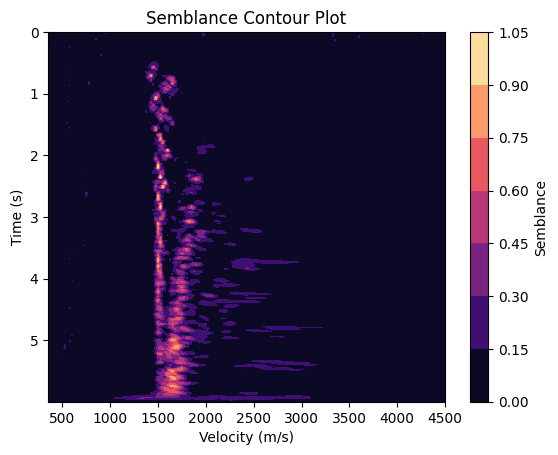

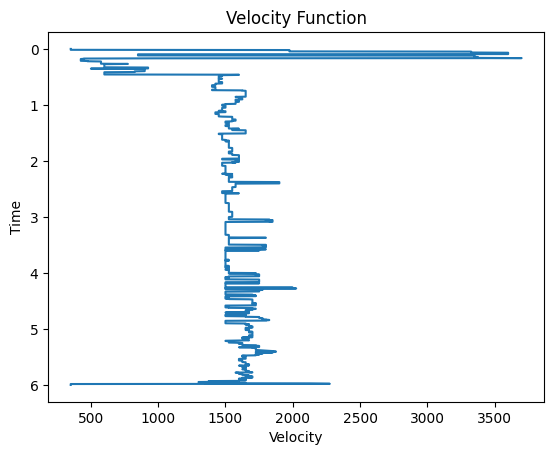

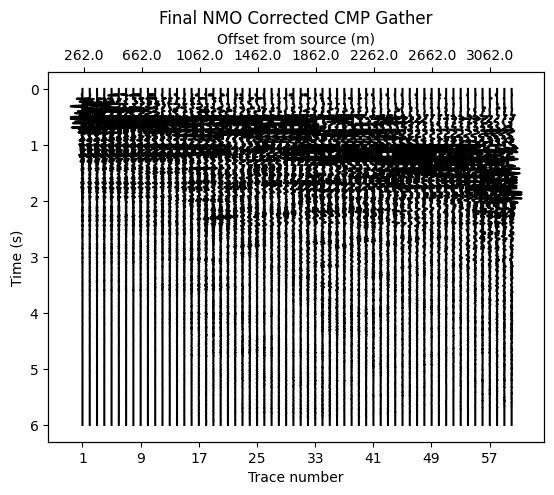

148


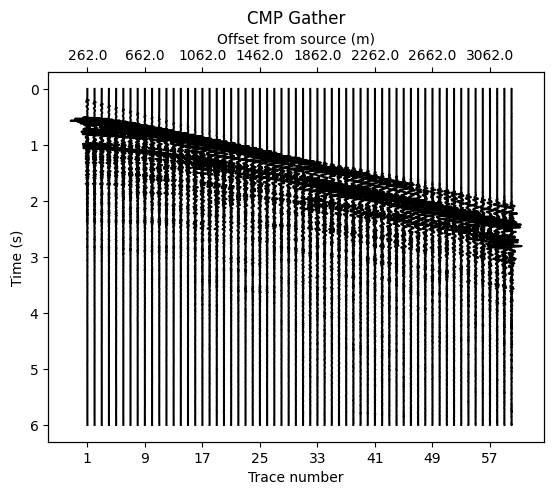

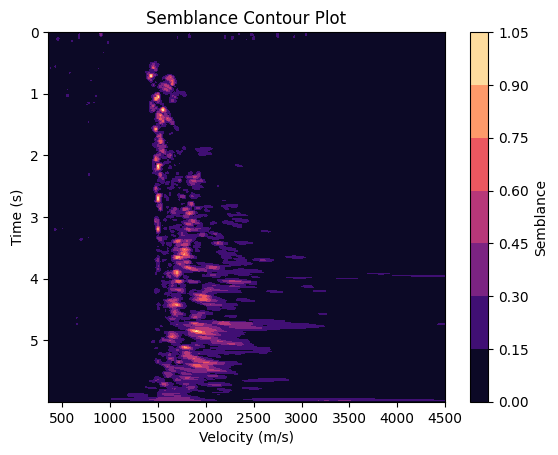

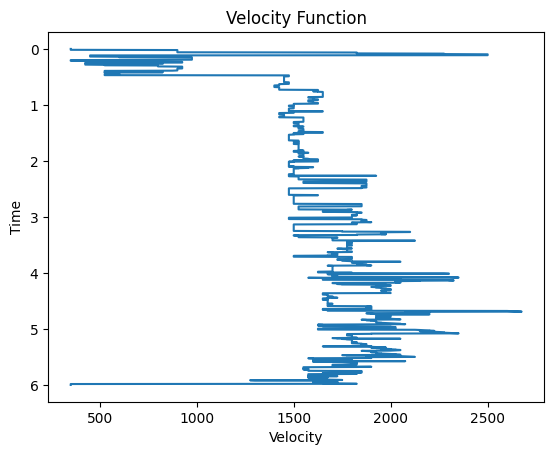

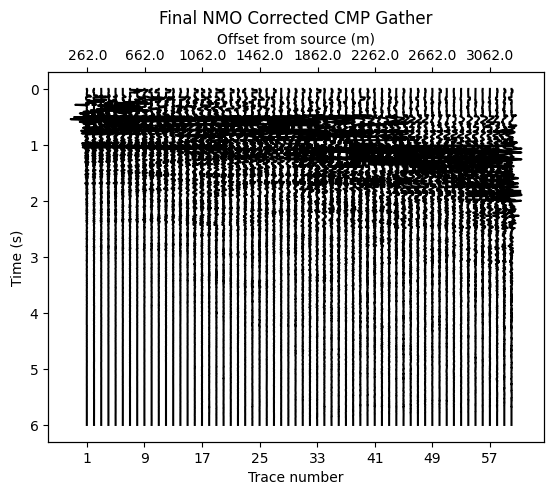

197


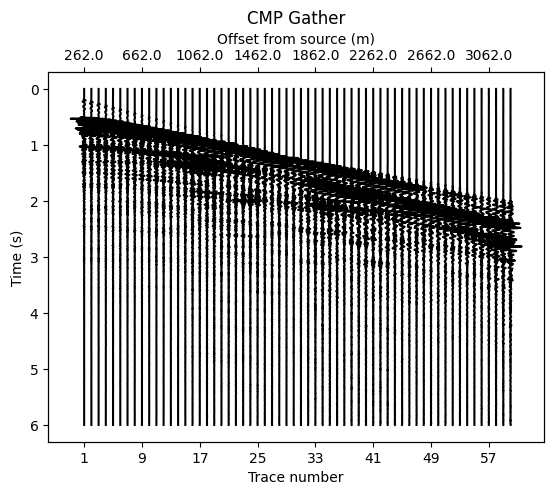

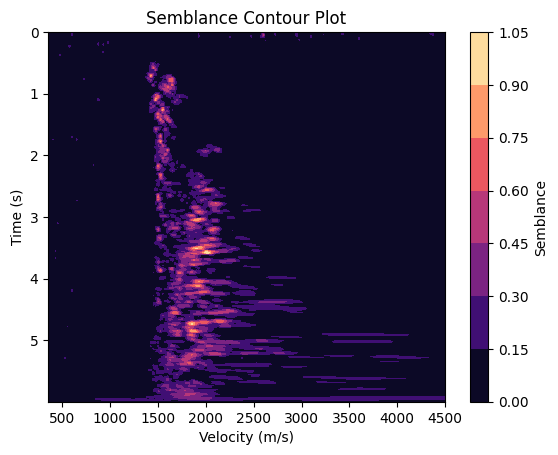

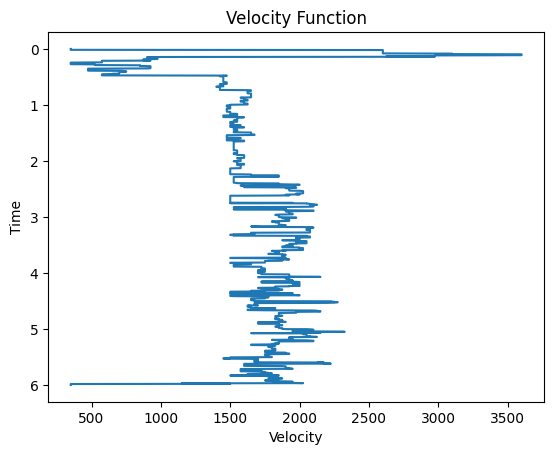

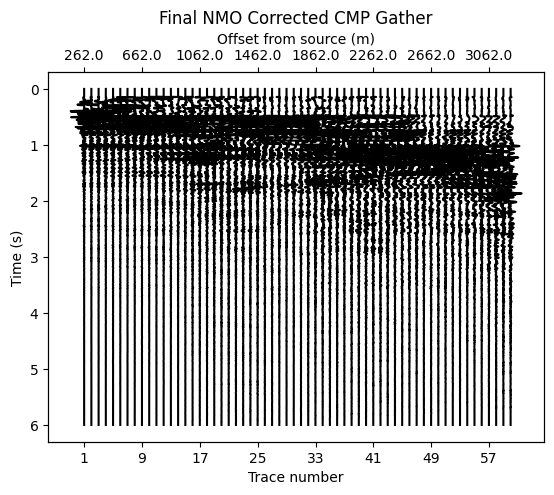

246


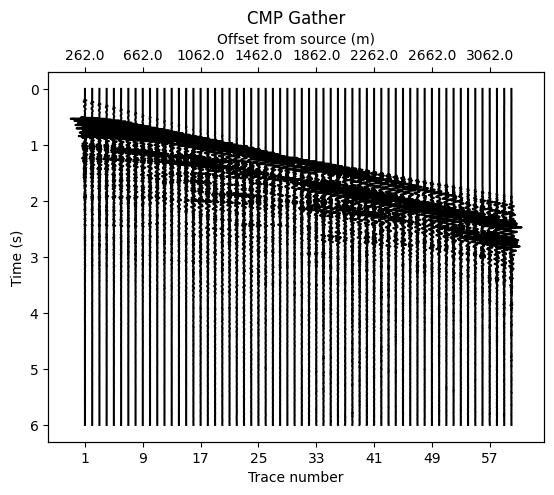

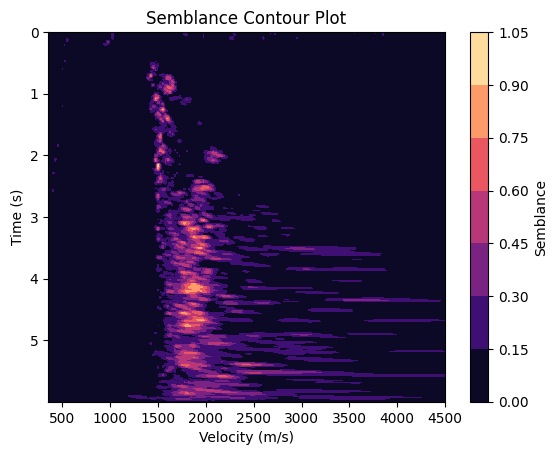

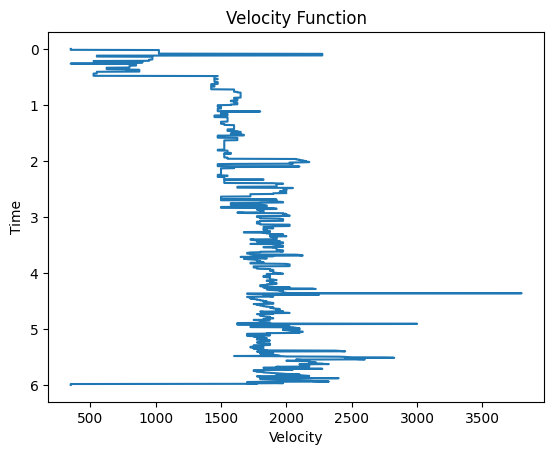

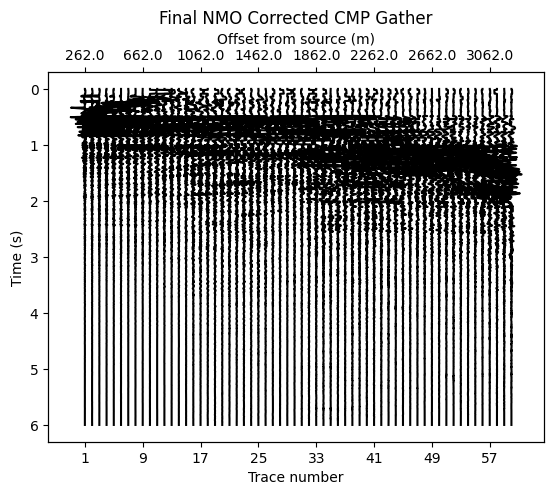

295


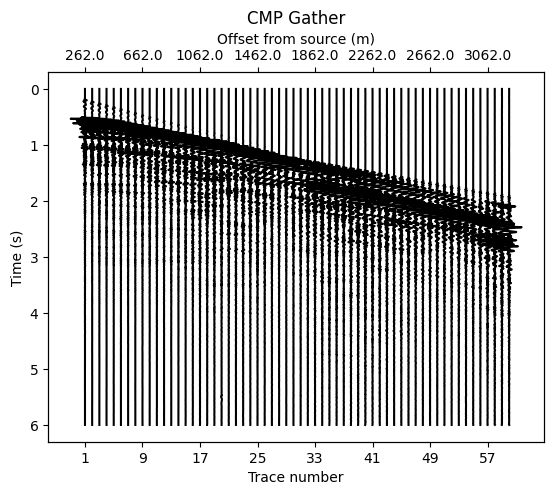

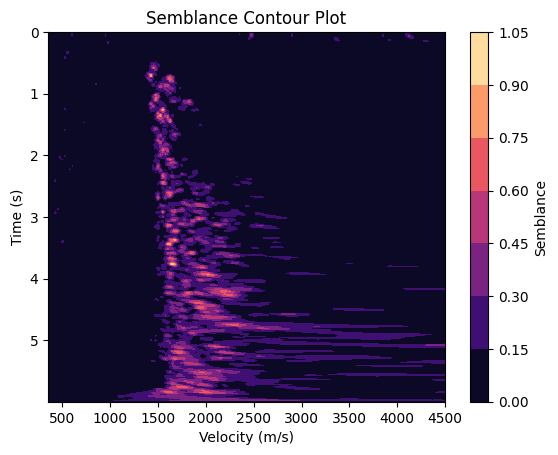

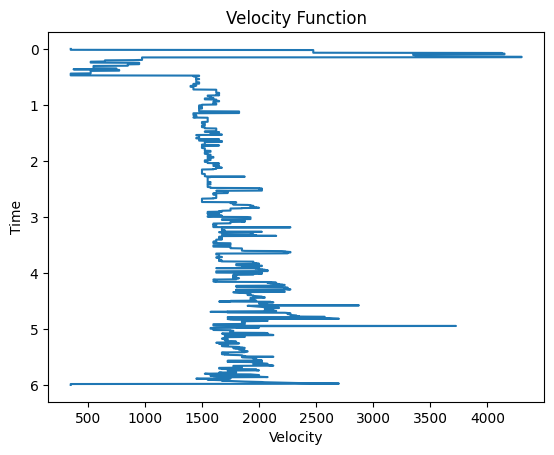

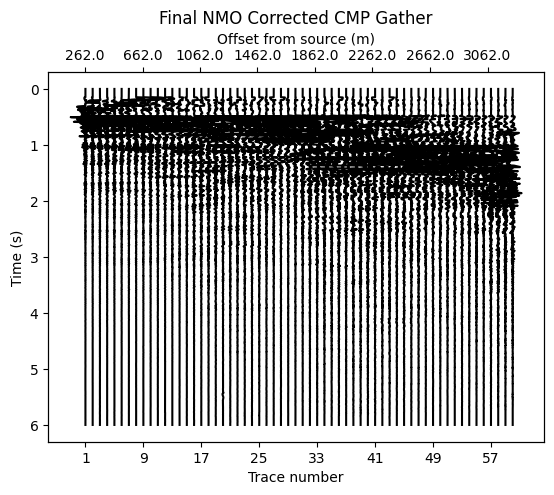

344


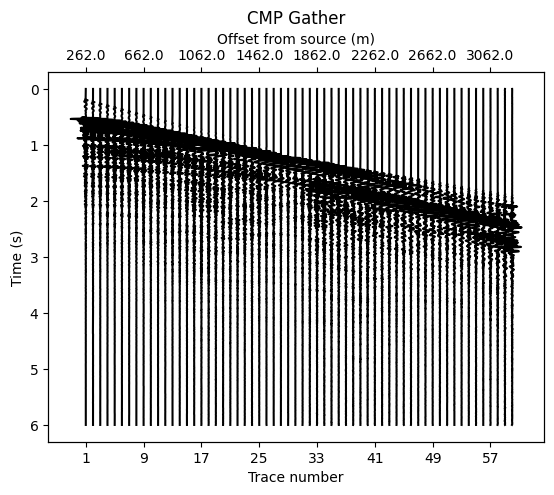

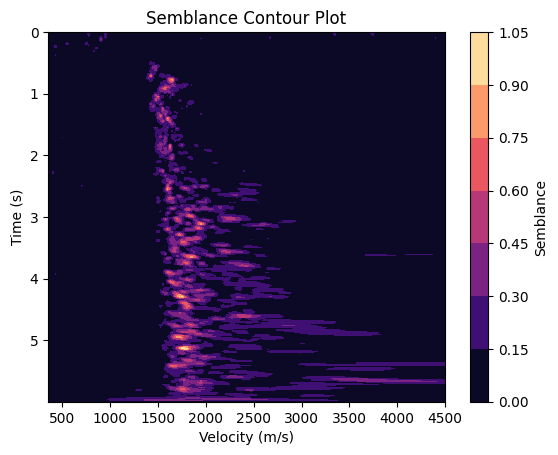

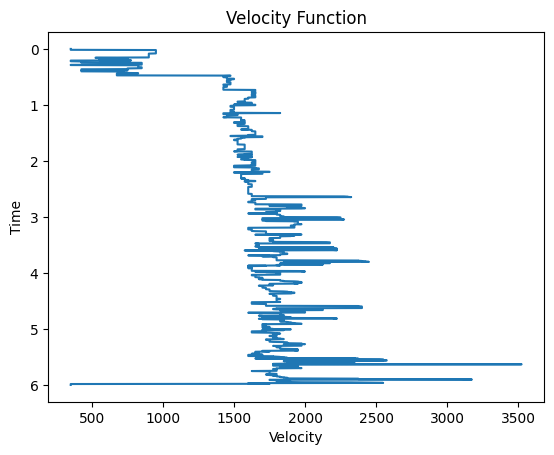

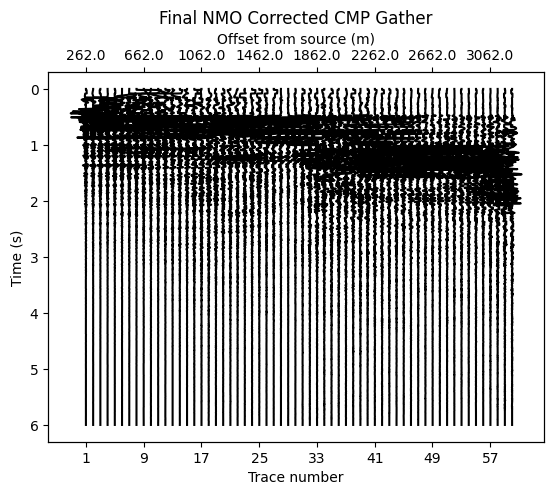

393


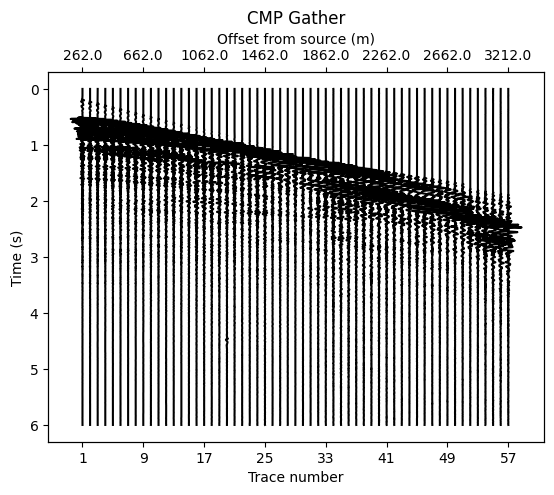

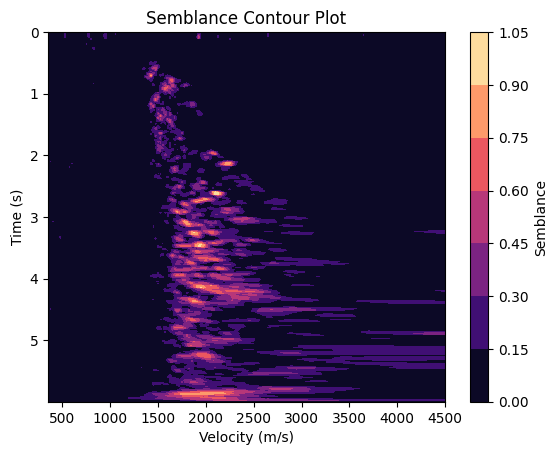

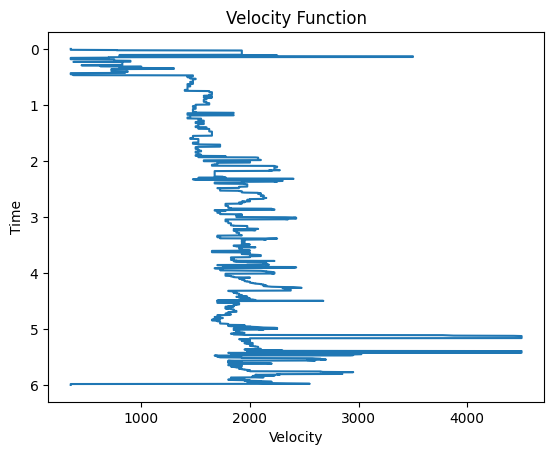

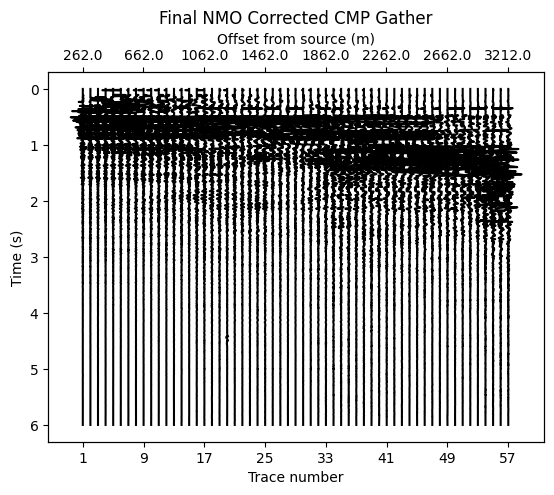

442


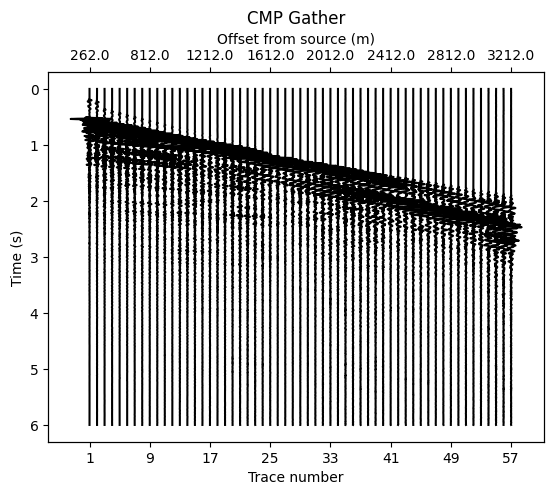

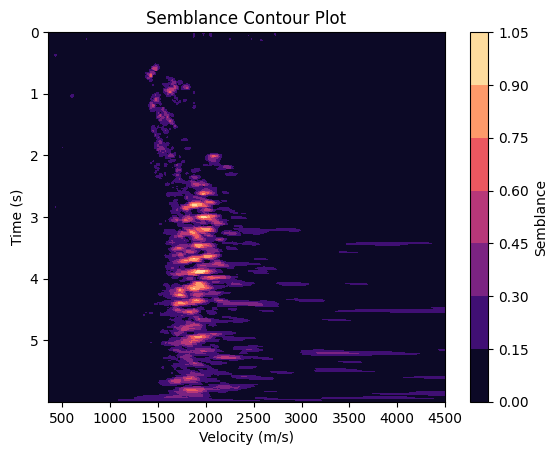

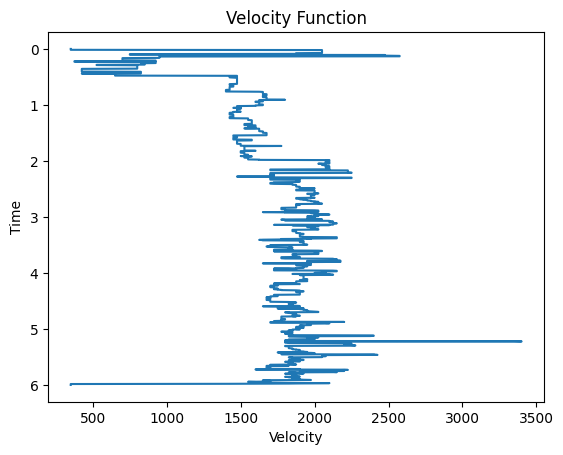

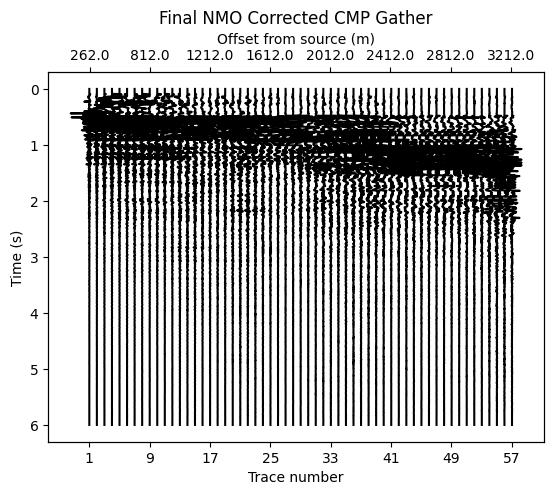

491


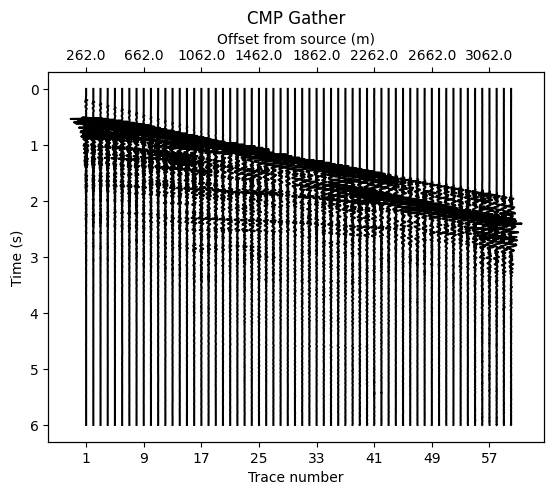

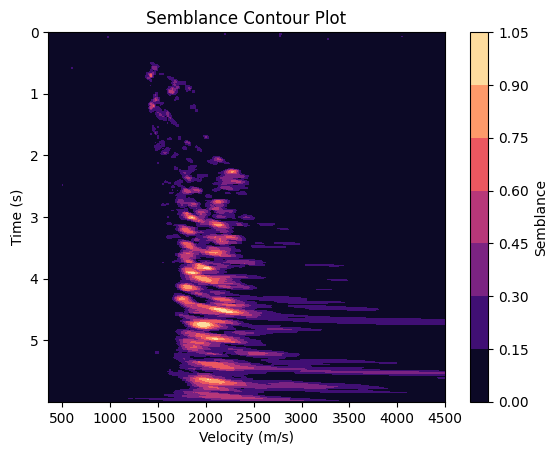

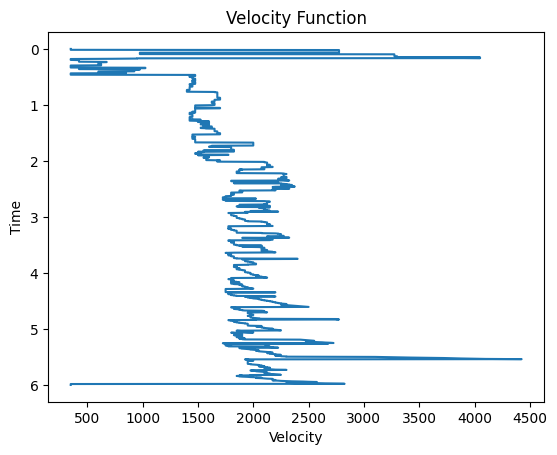

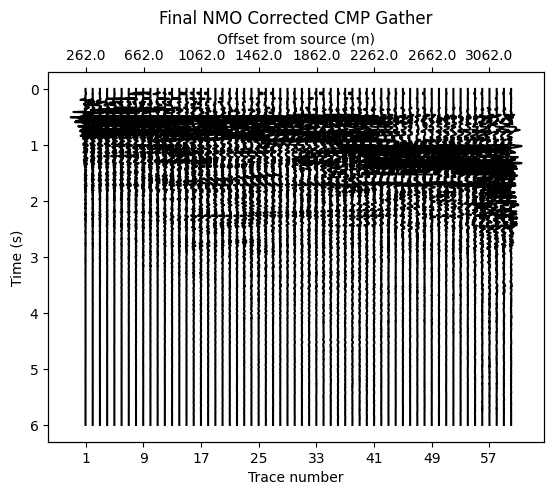

540


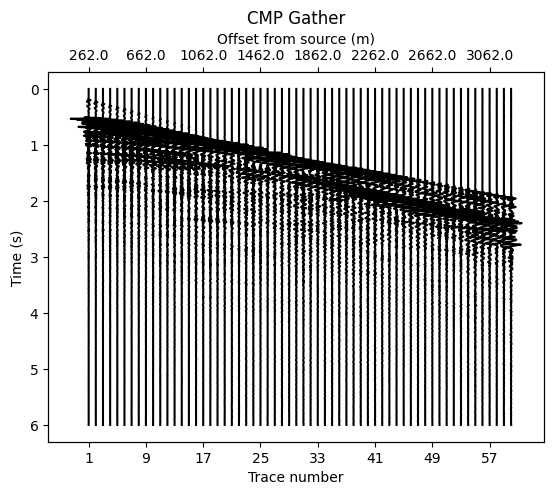

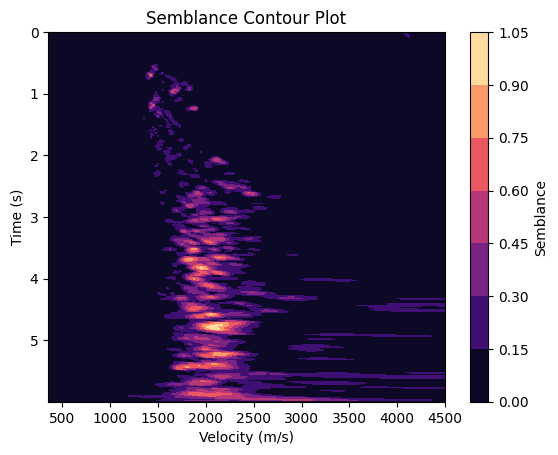

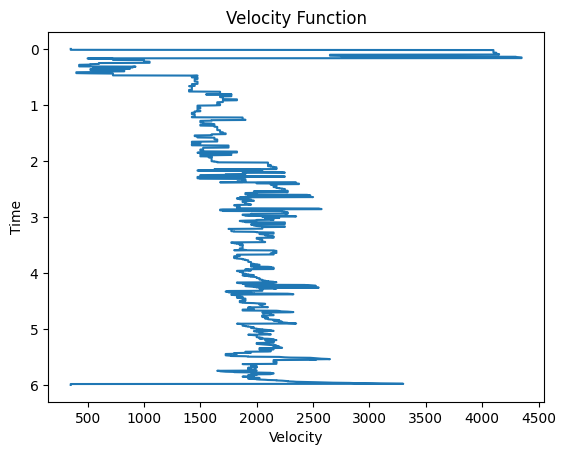

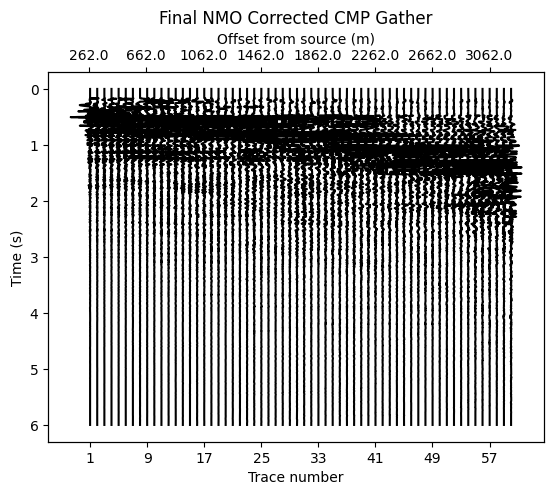

589


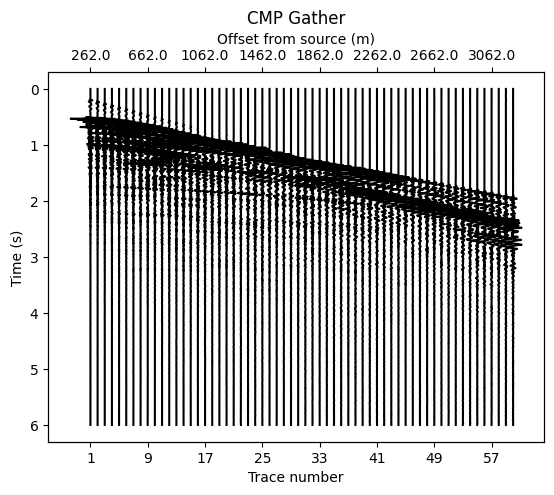

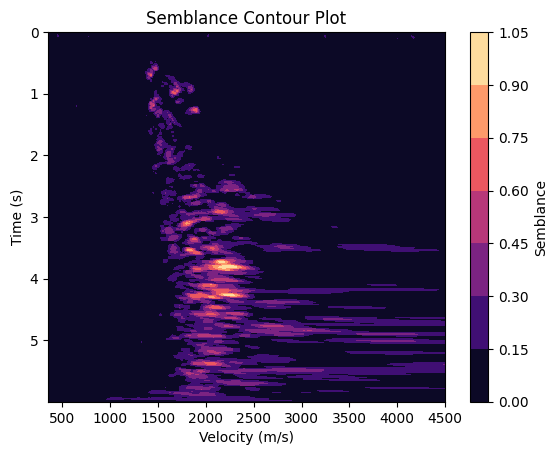

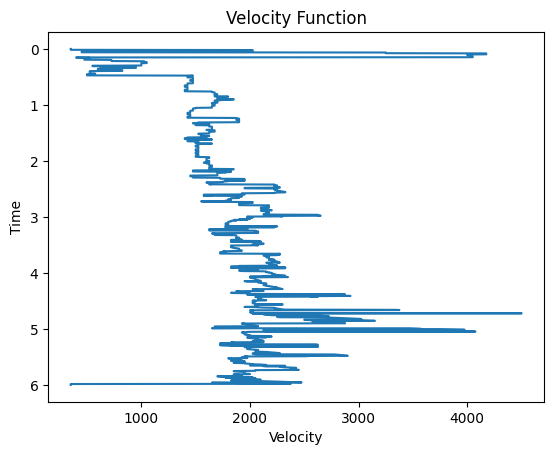

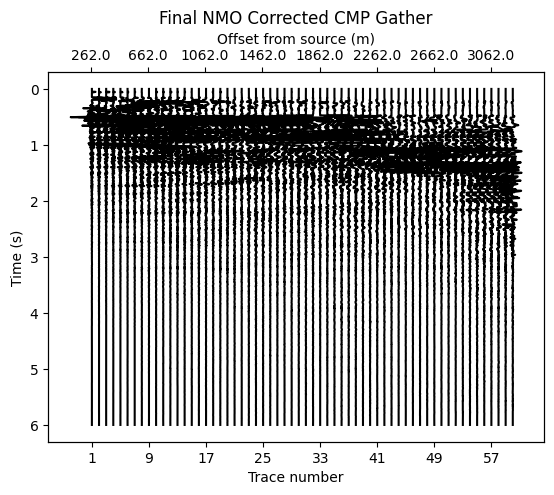

638


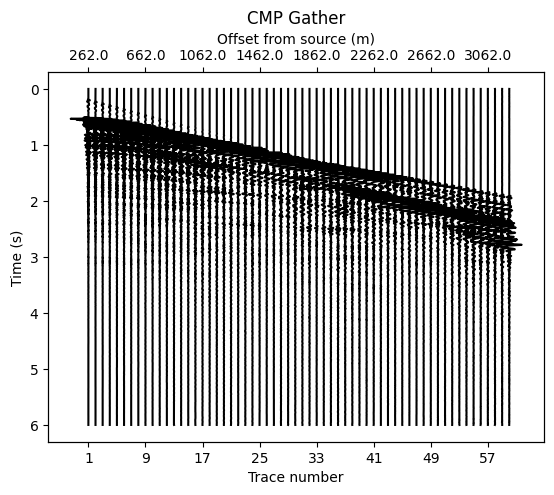

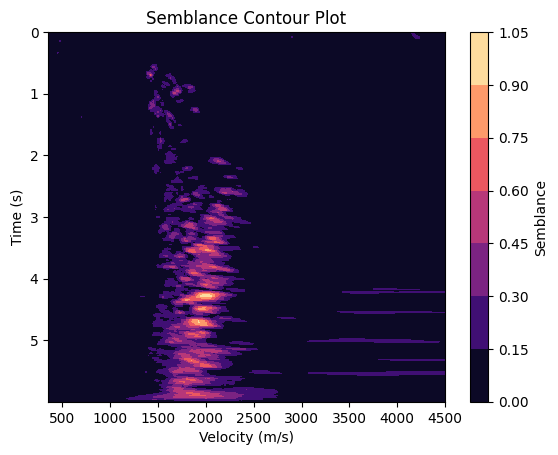

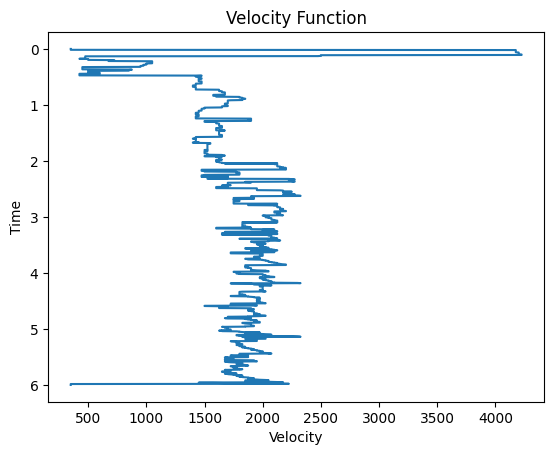

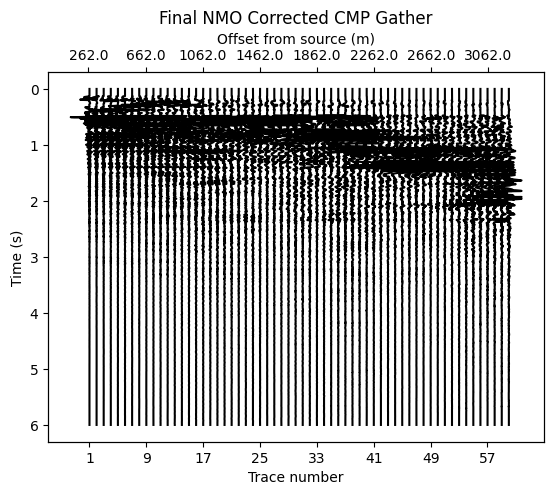

687


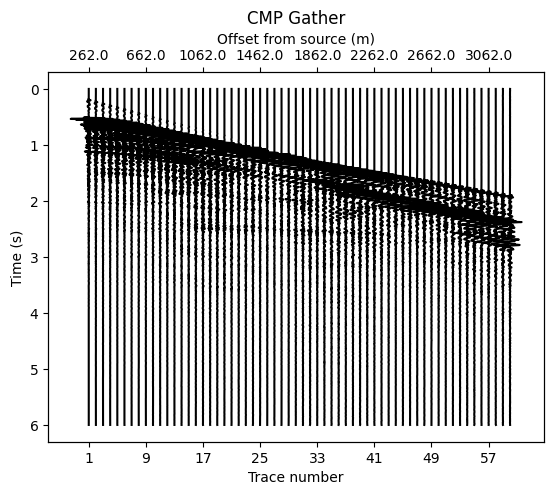

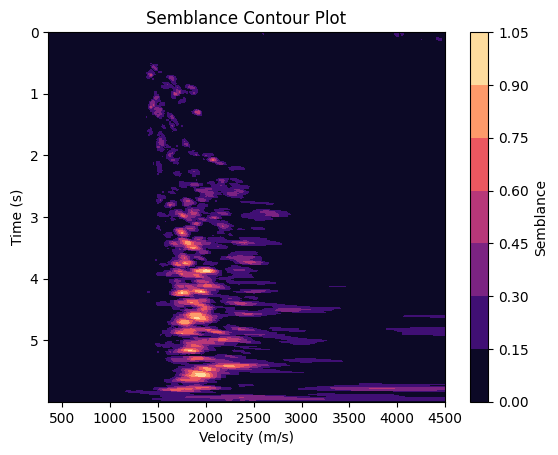

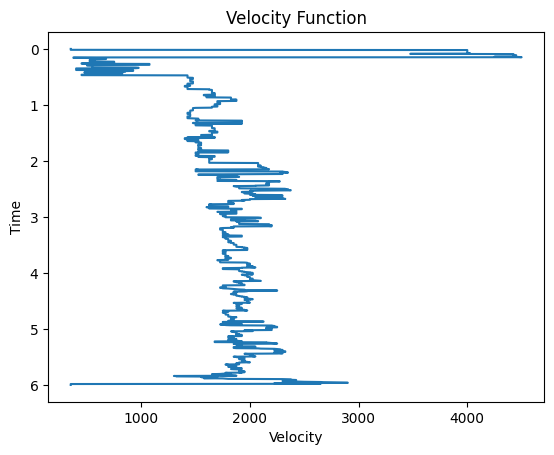

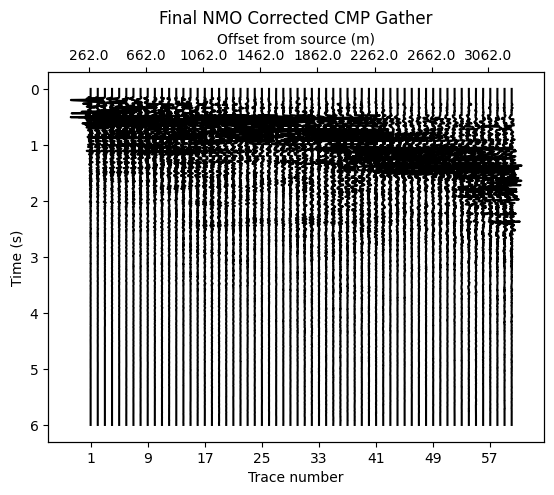

736


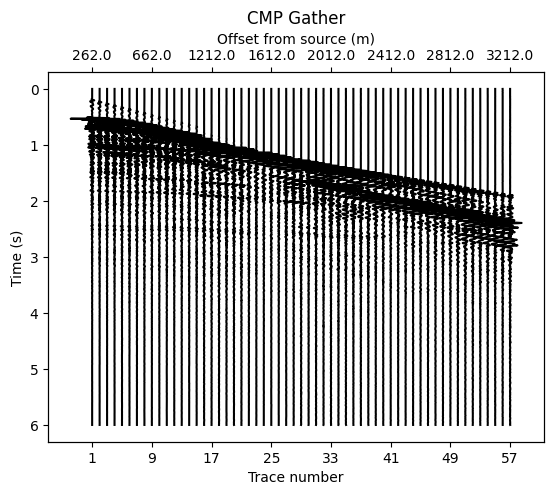

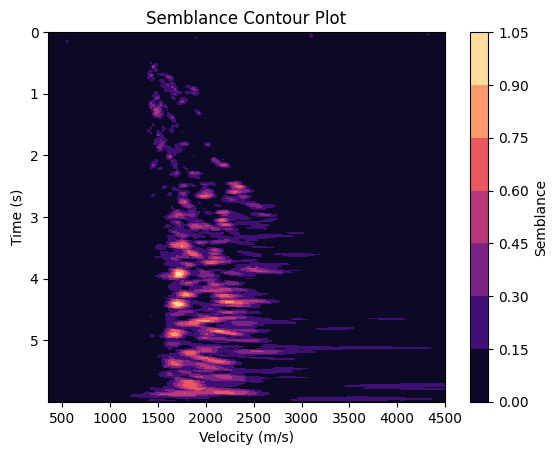

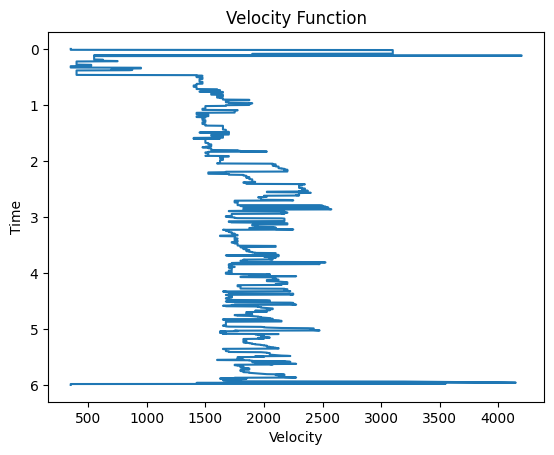

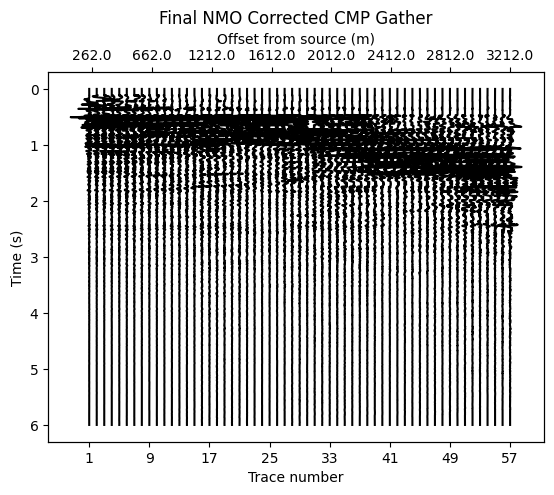

785


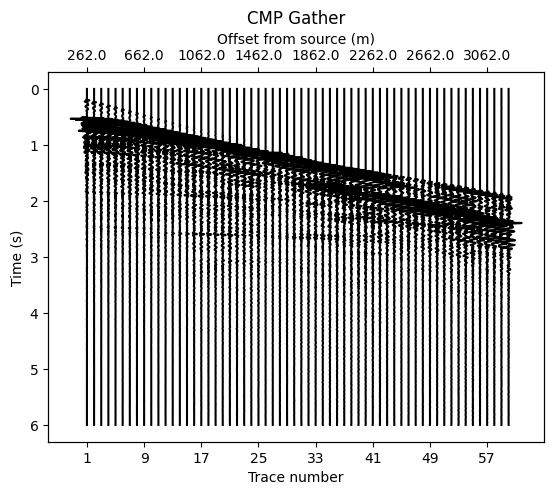

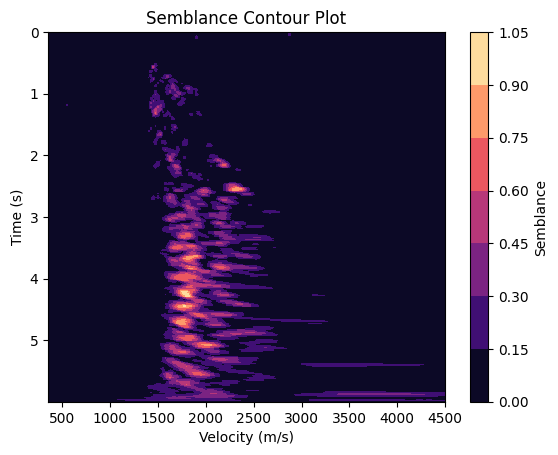

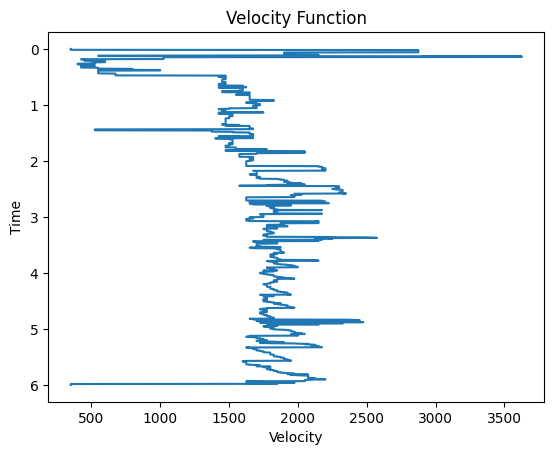

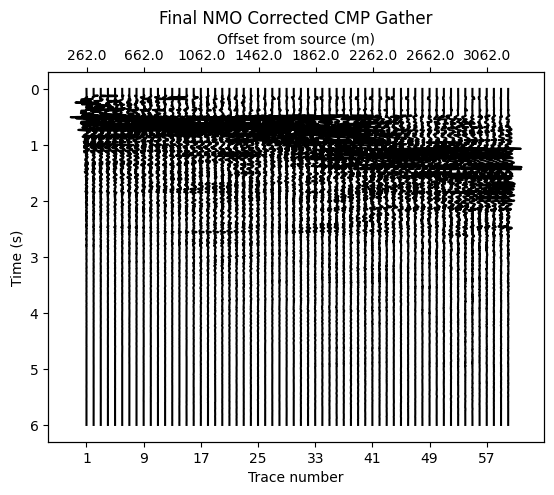

834


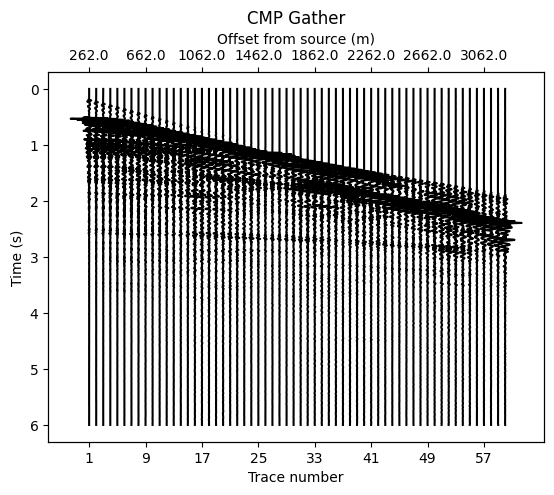

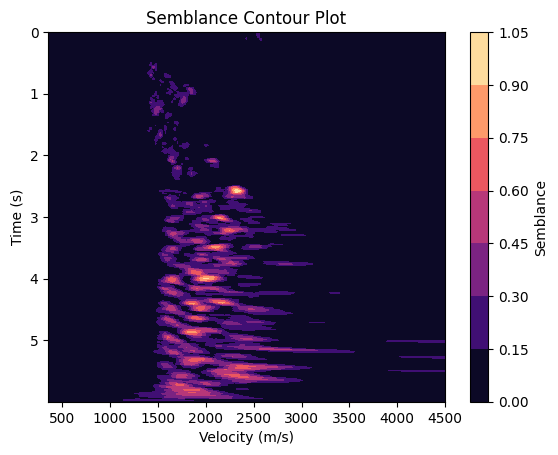

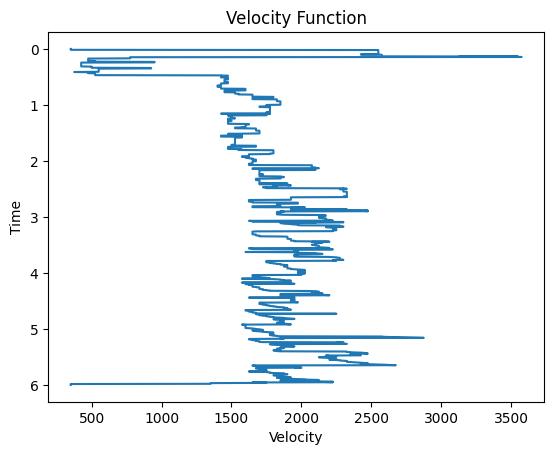

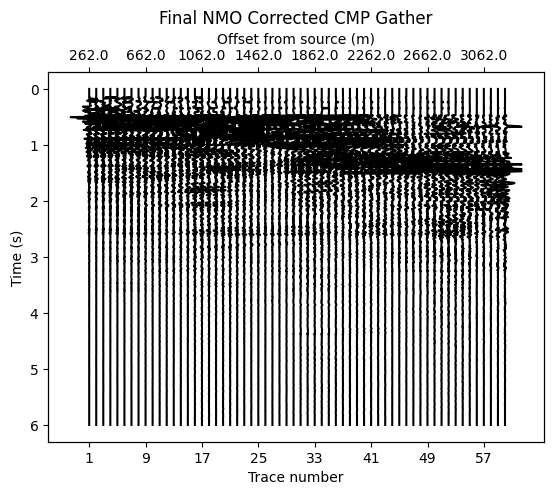

883


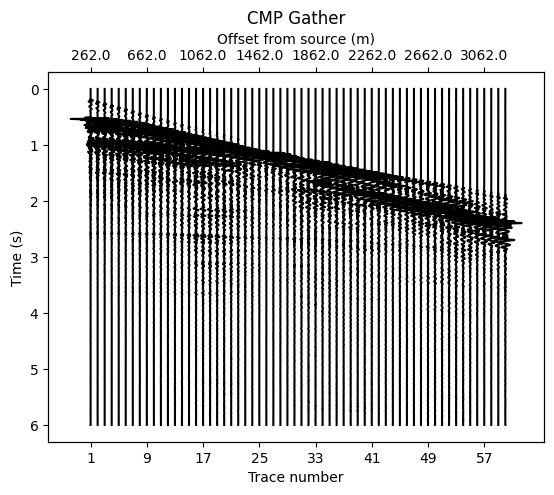

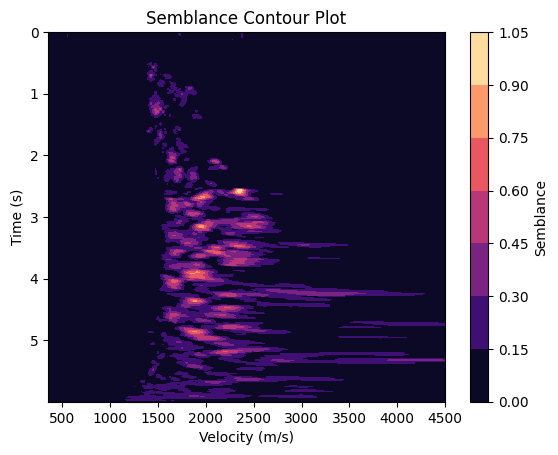

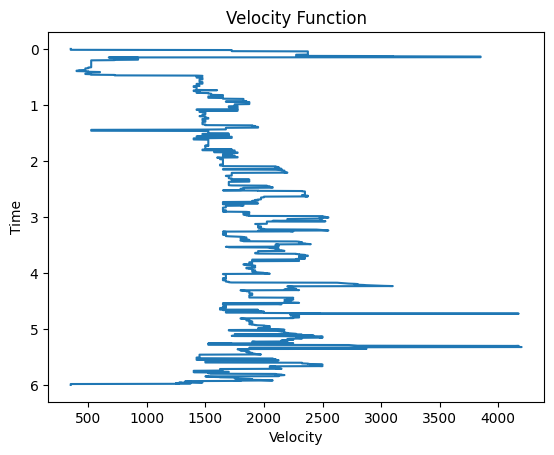

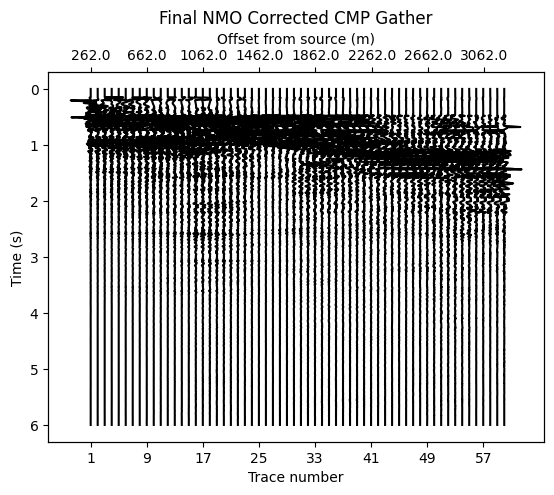

932


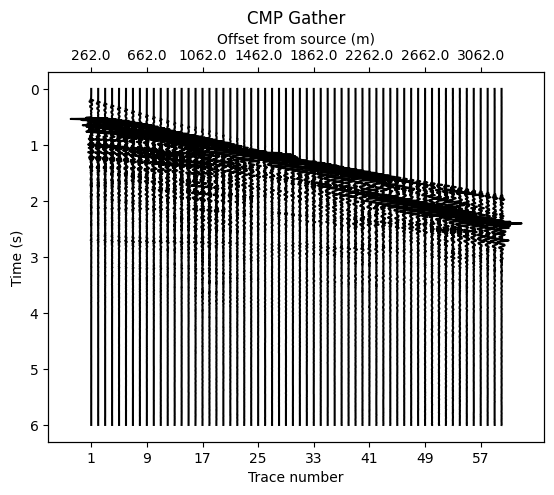

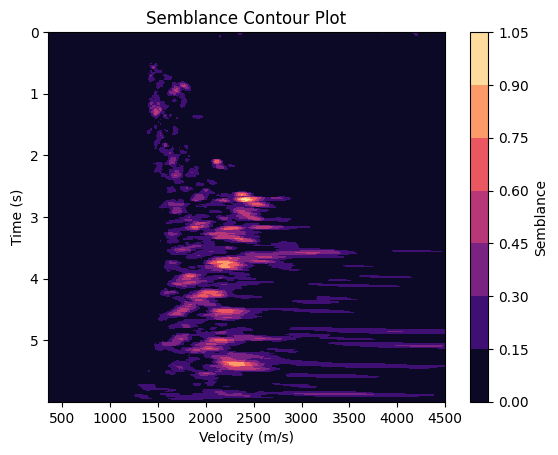

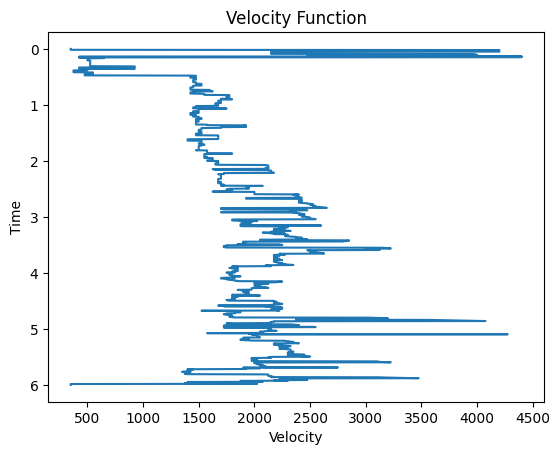

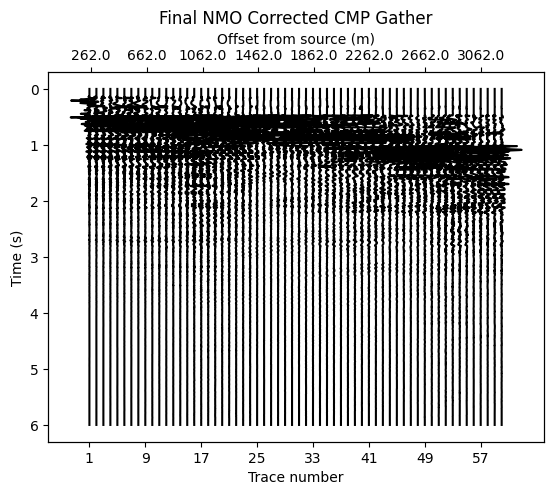

In [17]:
file_semb = 'C:/Users/abdul/Downloads/Ejaz/sembs.xlsx' ## path where semblance analysis matrices are saved (sembs.xlsx). Check 
## VikingAT_CMPstack jupyter notebook
file_sgs = 'C:/Users/abdul/Downloads/Ejaz/sgs.xlsx' ## path where cmp gathers are saved (sgs.xlsx)
cmp_stack=[]
vel = np.arange(350,4501,25)

for i in range(1,942,49):
    print(i)
    nsheet_name=f'sheet_{i}'

    sg, offsets = extsg(sg2,i)
    # sg = pd.read_excel(file_sgs, sheet_name=nsheet_name)

    sg=sg.values
    # print('sg done')
    # print(sg[2,3])
    sz = sg.shape
    sgn = balance_seismic_data(sg) ## balancing the cmp gather


### Plotting normalized cmp gather
    
    sn2 = np.zeros_like(sgn)
    for k in range(sz[1]):
        sn2[:,k] = sgn[:,k] + k*5.5


    fig, ax1 = plt.subplots()
    ax1.plot(sn2[:, :sz[1]], t, 'k')
    ax1.invert_yaxis()  # Reverse the y-axis

    # Extract x-tick positions
    xtick_positions = np.mean(sn2[:, list(range(0,sz[1],8))], axis=0) 
    # Set x-tick marks and labels for the bottom axes
    ax1.set_xticks(xtick_positions)
    ax1.set_xticklabels(list(range(1,sz[1]+1,8)))

    ax2 = ax1.twiny()

    # Set x-tick marks and labels for the top axes
    xtick_positions_top = np.mean(sn2[:, list(range(0,sz[1],8))], axis=0) 
    ax2.set_xticks(xtick_positions_top)
    ax2.set_xticklabels(offsets.tolist()[0:sz[1]:8])
    
    ax2.set_xlim(ax1.get_xlim())
    
    ax1.set_xlabel('Trace number')
    ax2.set_xlabel('Offset from source (m)')
    
    # Set label for y-axis
    ax1.set_ylabel('Time (s)')
    plt.title('CMP Gather')

    plt.show()
    

### reading semblance values
    semb = pd.read_excel(file_semb, sheet_name=nsheet_name, header=None)
    semb=semb.values

### Plotting semblance contour

    fig, ax3 = plt.subplots()
    contour = ax3.contourf(vel, t, semb / np.max(semb), cmap='magma')
    ax3.invert_yaxis()  # Reverse the y-axis
    ax3.set_ylabel('Time (s)')
    ax3.set_xlabel('Velocity (m/s)')
    
    plt.title('Semblance Contour Plot')
    
    # Add colorbar using the result of contourf as the mappable
    cbar = plt.colorbar(contour, ax=ax3, label='Semblance')
    
    # Show the plot
    plt.show()

#### Extracing and plotting velocity function with time (from semblance analysis/contour plot)
    mxi = np.argmax(semb, axis=1)
    # Find the maximum values in each row
    mxv = semb[np.arange(len(semb)), mxi]
    velm = vel[mxi] # velocity function

    plt.plot(velm,t)
    plt.gca().invert_yaxis()
    # Add labels and title
    plt.xlabel('Velocity')
    plt.ylabel('Time')
    plt.title('Velocity Function')
    plt.show()


### Final NMO correction using velocity function
    final_nmc = f_nmo_correction(sgn, dt, offsets, velm)

    
### Plotting final NMO corrected CMP gather
    sn3 = np.zeros_like(final_nmc)
    for k in range(sz[1]):
        sn3[:,k] = final_nmc[:,k]+k*5.5

    fig, ax4 = plt.subplots()
    ax4.plot(sn3[:, :sz[1]], t, 'k')
    ax4.invert_yaxis()  # Reverse the y-axis

    # Extract x-tick positions
    xtick_positions = np.mean(sn3[:, list(range(0,sz[1],8))], axis=0) #s2[:, [0, 9, 19, 29, 39, 49, 59]].mean().values
    # Set x-tick marks and labels for the bottom axes
    ax4.set_xticks(xtick_positions)
    ax4.set_xticklabels(list(range(1,sz[1]+1,8)))

    ax5 = ax4.twiny()

    # Set x-tick marks and labels for the top axes
    xtick_positions_top = np.mean(sn3[:, list(range(0,sz[1],8))], axis=0) #s2[:, [0, 9, 19, 29, 39, 49, 59]].mean().values
    ax5.set_xticks(xtick_positions_top)
    ax5.set_xticklabels(offsets.tolist()[0:sz[1]:8])
    
    ax5.set_xlim(ax1.get_xlim())
    
    ax4.set_xlabel('Trace number')
    ax5.set_xlabel('Offset from source (m)')
    
    # Set label for y-axis
    ax4.set_ylabel('Time (s)')

    plt.title('Final NMO Corrected CMP Gather')
    plt.show()


### CMP Stacking 
    stack = np.sum(final_nmc, axis=1, keepdims=True)
    stack_bal = balance_seismic_data(stack)
    cmp_stack.append(stack_bal)




In [ ]:
off = np.array([0])
k=1
z=0
for i in range(50,942,49):
    idx = slist.index(i)
    # print('idx= ',idx)
    val = slistc[idx] - k
    # print('\n','val= ',val)
    off=np.append(off,off[z]+val*25)
    # print('\n',off)
    k=slistc[idx]
    z+=1

NameError: name 'off' is not defined

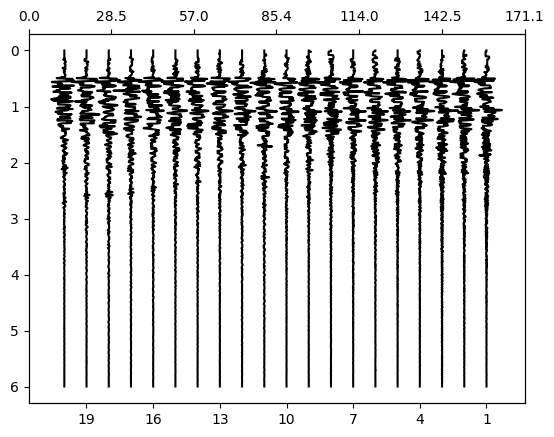

In [18]:
cmp_st = np.column_stack(cmp_stack)
cmp_stk = np.zeros_like(cmp_st)
for i in range((cmp_st.shape[1])):
    cmp_stk[:,i] = cmp_st[:,i]+i*9.5


fig, ax1 = plt.subplots()
ax1.plot(cmp_stk[:, :cmp_stk.shape[1]], t, 'k')
ax1.invert_yaxis()  # Reverse the y-axis
ax1.invert_xaxis()

# Extract x-tick positions
xtick_positions = np.mean(cmp_stk[:, list(range(0,cmp_stk.shape[1],3))], axis=0) #s2[:, [0, 9, 19, 29, 39, 49, 59]].mean().values
# Set x-tick marks and labels for the bottom axes
ax1.set_xticks(xtick_positions)
ax1.set_xticklabels(list(range(1,cmp_stk.shape[1],3)))

ax2 = ax1.twiny()

# Set x-tick marks and labels for the top axes
xtick_positions_top = np.mean(cmp_stk[:, list(range(0,cmp_stk.shape[1],3))], axis=0) #s2[:, [0, 9, 19, 29, 39, 49, 59]].mean().values
ax2.set_xticks(xtick_positions_top)
ax2.set_xticklabels(off.tolist()[0:cmp_stk.shape[1]:3])

ax2.set_xlim(ax1.get_xlim())

ax1.set_xlabel('CMP stacked trace number')
ax2.set_xlabel('CMP distance along survey line (m)')

# Set label for y-axis
ax1.set_ylabel('Time (s)')
plt.title('CMP Stack Traces')

plt.show()